In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import copy
import os

from einops import rearrange
from einops.layers.torch import Rearrange

import torch
import Simple_ViT.simple_vit as svit
import Simple_ViT.simple_vit_lrp as svitl

import importlib
# When you need to reload the module after an update
importlib.reload(svitl)

## GPU Handling

In [2]:
def set_gpu(gpu_id):
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
gpu_id=-1

if gpu_id >= 0:
    device = "cuda"
    set_gpu(gpu_id)
    print('device available :', torch.cuda.is_available())
    print('device count: ', torch.cuda.device_count())
    print('current device: ',torch.cuda.current_device())
    print('device name: ',torch.cuda.get_device_name())
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cpu')

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

print('using device: ', device)

using device:  cpu


## Functions

In [3]:
class RegressionCNN(nn.Module):
    def __init__(self, input_shape, num_classes=9):
        """
        Initialize the CNN model.
        
        Parameters:
            input_shape (tuple): The shape of the input images (C, H, W).
            num_classes (int): The number of classes for prediction.
        """
        super(RegressionCNN, self).__init__()
        self.flatten = nn.Flatten()
        
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Calculate the size of the flattened features after conv and pooling layers
        self.flattened_size = 64 * (input_shape[1] // 4) * (input_shape[2] // 4)
        
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        """
        Forward pass through the model.
        
        Parameters:
            x (torch.Tensor): Input tensor.
        
        Returns:
            torch.Tensor: The output of the network.
        """
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # x = x.view(-1, self.flattened_size)  # Flatten the tensor for the fully connected layer
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class RegressionANN(nn.Module):
    def __init__(self, input_shape, num_classes=9):
        """
        Initialize the CNN model.
        
        Parameters:
            input_shape (tuple): The shape of the input images (C, H, W).
            num_classes (int): The number of classes for prediction.
        """
        super(RegressionANN, self).__init__()
        
        # Calculate the size of the flattened features after conv and pooling layers
        self.flattened_size = (input_shape[1])

        self.flatten = nn.Flatten()
        self.fc0 = nn.Linear(self.flattened_size,1024)
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, num_classes)
        
    def forward(self, x):
        """
        Forward pass through the model.
        
        Parameters:
            x (torch.Tensor): Input tensor.
        
        Returns:
            torch.Tensor: The output of the network.
        """
        # x = x.view(-1, self.flattened_size)  # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = (self.fc7(x))
        return x

class Regression_Linear(nn.Module):
    def __init__(self, input_shape, num_classes=9):
        """
        Initialize the CNN model.
        
        Parameters:
            input_shape (tuple): The shape of the input images (C, H, W).
            num_classes (int): The number of classes for prediction.
        """
        super(Regression_Linear, self).__init__()
        
        # Calculate the size of the flattened features after conv and pooling layers
        self.flattened_size = (input_shape[1]) * (input_shape[2])
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self.flattened_size,num_classes)
        
    def forward(self, x):
        """
        Forward pass through the model.
        
        Parameters:
            x (torch.Tensor): Input tensor.
        
        Returns:
            torch.Tensor: The output of the network.
        """
        # x = x.view(-1, self.flattened_size)  # Flatten the tensor for the fully connected layer
        x = self.flatten(x)
        x = (self.fc1(x))
        return x


class SpatialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.nan_to_num(torch.tensor(X, dtype=torch.float32))
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx].unsqueeze(0)

class SpatialDataset_ANN(Dataset):
    def __init__(self, X, y):
        self.X = torch.nan_to_num(torch.tensor(X, dtype=torch.float32)).squeeze()
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx].unsqueeze(0)

class SpatialDataset_ANN(Dataset):
    def __init__(self, X, y):
        # Convert inputs to tensors
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)
        
        # Flatten X_tensor to check for NaNs across all dimensions of each sample
        flattened_X = X_tensor.view(X_tensor.size(0), -1)
        
        # Identify samples with NaN in either X or y
        mask = ~torch.isnan(flattened_X).any(dim=0)
        
        # Filter out samples where either X or y has NaN
        self.X = flattened_X[:, mask]
        self.y = y_tensor
    
    def __len__(self):
        # The length of the dataset is the length of the cleaned X or y
        return len(self.X)
    
    def __getitem__(self, idx):
        # Get an item and return it, ensure y is returned with an extra dimension if needed
        return self.X[idx], self.y[idx].unsqueeze(0)

## Import Dataset

In [4]:
dir_fil = '/glade/work/wchapman/ViT_XAI/Data_Staging/Mamalakis_Dataset/scp_synth_exm_data.nc'
Data_ = xr.open_dataset(dir_fil)
Data_train = np.expand_dims(Data_['SSTrand'].isel(time=slice(0,900000)),1)
Y_train = np.array(Data_['y'].isel(time=slice(0,900000)))

Data_val = np.expand_dims(Data_['SSTrand'].isel(time=slice(950000,1000000)),1)
Y_val = np.array(Data_['y'].isel(time=slice(950000,1000000)))

Data_test = np.expand_dims(Data_['SSTrand'].isel(time=slice(900000,950000)),1)
Y_test = np.array(Data_['y'].isel(time=slice(900000,950000)))

## Train Model

In [6]:
rem = Data_train.shape
input_shape = (1,1, 36, 18) # Example input shape (C, H, W)

#(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,num_heads=12, mlp_ratio=4., qkv_bias=False, mlp_head=False, drop_rate=0., attn_drop_rate=0.):

model = svitl.VisionTransformer(
        image_lr = 36,
        image_ud = 18,
        patch_size = 9,
        num_classes = 1,
        in_chans = 1,
        embed_dim = 1024,
        depth = 8,
        num_heads = 32,
        mlp_ratio = 4.,
    ).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00003)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

train_dataset = SpatialDataset(Data_train, Y_train)
val_dataset = SpatialDataset(Data_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size=400, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=400, shuffle=False)

In [8]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    print(f"Starting Epoch {epoch}")
    nsampsseen = 0
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        nsampsseen += inputs.shape[0]
        if nsampsseen > 100000:
            break
    epoch_loss = running_loss / nsampsseen
    print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    mse_val_batch=[]
    with torch.no_grad():  # In validation phase, we don't need to compute gradients
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs.to(device))
            mse_val_batch.append((torch.mean((outputs-labels)**2)))
    # Calculate and print validation accuracy
    mse_tot=torch.mean(torch.tensor(mse_val_batch))
    
    print(f"MSE: {mse_tot:.5f}")
    print( f"r2: {1-(mse_tot/np.var(Y_val))}")
    
    if epoch == 0:
        print('...saved first epoch...')
        best_mod = copy.deepcopy(model)
        best_acc = copy.deepcopy(mse_tot)
    elif mse_tot<best_acc:
        print('...saving!...')
        best_mod = copy.deepcopy(model)
        best_acc = copy.deepcopy(mse_tot)
    else:
        print('No improvement in validation accuracy.')
    # Step the scheduler on each epoch
    scheduler.step(mse_tot)

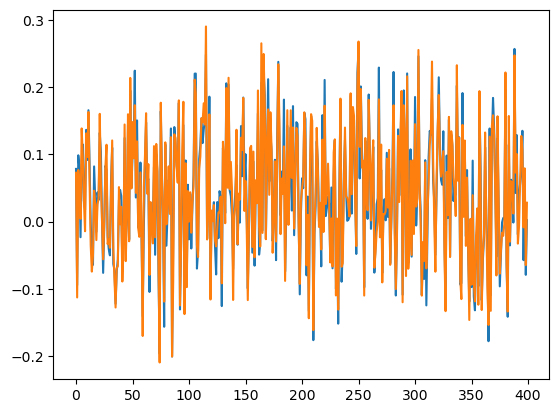

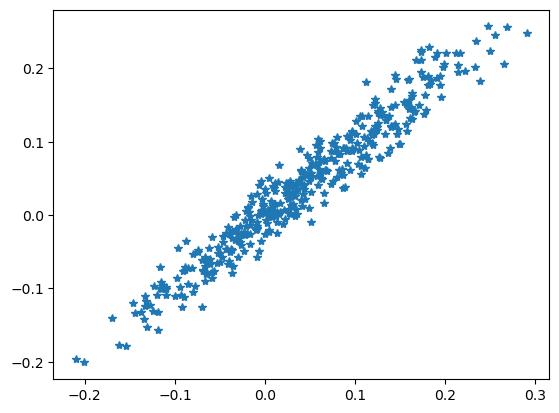

In [33]:
plt.plot(labels.cpu().detach().numpy())
plt.plot(best_mod(inputs).cpu().detach().numpy())
plt.show()

plt.plot(best_mod(inputs).cpu().detach().numpy(),labels.cpu().detach().numpy(),'*')
plt.show()

In [10]:
PATH = 'saved_models/benchmark/model001.pt'
torch.save(best_mod, PATH)